In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import scanpy as sc
import anndata as an
from textwrap import fill
import scipy
import sklearn
import gget

from importlib import reload
import utils as ut
import plotting as plt2

In [2]:
sc.settings.verbosity = 4

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.75 GB, difference +8.75 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs_names.nunique()

54347

# Subset the data

In [5]:
# Filter for the relevant cell types: Hematopoietic stem cells (HSC) and induced HSC (iHSC)
cell_types = ['HSC', 'iHSC']
pdf = adata[adata.obs['cell_type'].isin(cell_types), :].copy()  # Explicit copy for safety

print("Number of cells after cell type filtering:", pdf.shape[0])

# Further filter to include only datasets of interest: iHSC and young2_HSC
datasets = ['iHSC', 'young2_HSC']
pdf = pdf[pdf.obs['dataset'].isin(datasets), :]

print("Number of cells after dataset filtering:", pdf.shape[0])

sc.pp.filter_genes(pdf, min_cells=1) # remove genes only expressed in a single-cell

# Clean up cell IDs to remove "_iHSC" suffix
pdf.obs['cell_id'] = pdf.obs.index.str.replace("_iHSC", "")

# Display distribution of cells across the filtered datasets
print("Dataset distribution:")
print(pdf.obs['dataset'].value_counts()) 

pdf

Number of cells after cell type filtering: 14372
Number of cells after dataset filtering: 11817
Dataset distribution:
dataset
iHSC          8574
young2_HSC    3243
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 11817 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Add QC Variables

In [6]:
fpath = "../resources/qc_barcodes.csv"
codes = pd.read_csv(fpath)
codes['OG_cluster'] = codes['cluster_str']

# Column to exclude from suffixing
exclude_column = 'cell_id'

# Suffix to add
suffix = '_QC'

# Create new column names with suffixes
new_columns = [col + suffix if col != exclude_column else col for col in codes.columns]

# Rename columns in the DataFrame
codes.columns = new_columns

print(f"{pdf.obs.shape=} {codes.shape=}")


index = pdf.obs_names.copy()

pdf.obs = pd.merge(
    pdf.obs, 
    codes,
    how='left',
    left_on='cell_id',
    right_on='cell_id',
)

pdf.obs['OG_cluster_QC'] = pdf.obs['OG_cluster_QC'].fillna('HSC')
pdf.obs =  pdf.obs.set_index(index)

pdf.obs.head()

pdf.obs.shape=(11817, 11) codes.shape=(8563, 11)


,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,predicted_doublet_QC,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,8.989130,4.937538,...,False,C1,False,True,True,True,False,True,False,C1
AAACCCAAGTTGAAGT_iHSC,5488.0,iHSC,iHSC,nan,12413,1,Reprogrammed Cells,D2,7.586400,4.889987,...,False,C1,False,False,False,False,False,False,False,C1
AAACCCAAGTTGTCGT_iHSC,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,8.027761,3.311177,...,False,C4,False,False,True,False,False,False,False,C4
AAACCCACAGAAGCGT_iHSC,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.584245,2.674468,...,False,C2,False,True,False,True,False,False,False,C2
AAACCCACAGGAGGTT_iHSC,14427.0,iHSC,iHSC,nan,13436,1,Reprogrammed Cells,D2,9.509144,4.923519,...,False,C1,False,True,True,False,False,False,False,C1


In [7]:
pdf.obs['cell_type'].value_counts()

cell_type
iHSC    8574
HSC     3243
Name: count, dtype: int64

# New PCA

In [8]:
pdf

AnnData object with n_obs × n_vars = 11817 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC', 'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC', 'OG_cluster_QC'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

Performing PCA dimensionality reduction...
computing PCA
    with n_comps=50
    finished (0:04:37)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


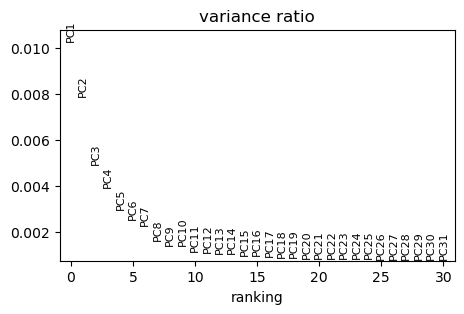

In [9]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    pdf, 
    n_comps=50, 
    mask_var=None,
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    pdf, 
)

# Distances

In [10]:
n_comps = 6
metric = 'cosine'

ihsc = pdf[pdf.obs['cell_type'] == 'iHSC', :].copy()
hsc = pdf[pdf.obs['cell_type'] == 'HSC', :].copy()

X_ihsc = ihsc.obsm['X_pca'][:, 0:n_comps]
X_hsc = hsc.obsm['X_pca'][:, 0:n_comps]

print(f"{X_ihsc.shape=}")
print(f"{X_hsc.shape=}")

D = cdist(
    X_ihsc, 
    X_hsc, 
    metric=metric,
)

D = pd.DataFrame(
    D, 
    index=ihsc.obs_names,
    columns=hsc.obs_names,
)

print(f"{D.shape=}")
print(f"Min Distance {np.min(D):4f}")
print(f"Max Distance {np.max(D):4f}")
print(f"Mean Distance {np.mean(D):4f}")

D.head()

X_ihsc.shape=(8574, 6)
X_hsc.shape=(3243, 6)
D.shape=(8574, 3243)
Min Distance 0.006581
Max Distance 1.998920
Mean Distance 1.169113


,AAACAGCCAACCCTAA-3_young2_HSC,AAACAGCCATAGGCGA-3_young2_HSC,AAACATGCAGGCTGTT-3_young2_HSC,AAACCGCGTCCTTAGT-3_young2_HSC,AAACCGCGTCCTTTAA-3_young2_HSC,AAACCGGCAATAGCCC-3_young2_HSC,AAACCGGCAATGCCCG-3_young2_HSC,AAACCGGCAGCCTTGG-3_young2_HSC,AAACGCGCACCAACCG-2_young2_HSC,AAACGGATCCCTGACT-3_young2_HSC,...,TTTGTCCCAATAATCC-3_young2_HSC,TTTGTCCCACTTCATC-3_young2_HSC,TTTGTCCCAGTCTAGC-3_young2_HSC,TTTGTCCCATTGTCCT-3_young2_HSC,TTTGTCTAGCAAGGGT-2_young2_HSC,TTTGTGAAGCCTAATA-3_young2_HSC,TTTGTGGCACACCAAC-3_young2_HSC,TTTGTGGCATCTAGCA-2_young2_HSC,TTTGTGGCATTGGGAG-3_young2_HSC,TTTGTTGGTACGTTTC-3_young2_HSC
AAACCCAAGGTTACCT_iHSC,1.217650,1.035922,1.245162,1.515226,0.973291,1.448503,1.267991,1.420485,1.102625,1.494384,...,1.382934,1.496911,1.397152,1.610255,1.313320,1.385413,1.547511,1.330043,1.560017,1.323599
AAACCCAAGTTGAAGT_iHSC,0.946126,1.021093,0.939056,1.318865,1.058889,1.335168,1.128192,1.090695,0.844698,1.216319,...,1.237103,1.204620,1.109304,1.305207,1.036317,1.145605,1.303439,1.064361,1.351055,1.016315
AAACCCAAGTTGTCGT_iHSC,1.214410,1.135448,1.221108,0.986796,1.147383,0.928563,1.182004,0.731878,1.115341,0.737573,...,1.158464,0.986859,1.149226,0.921457,1.263733,0.948917,1.056092,1.232115,0.987098,1.026162
AAACCCACAGAAGCGT_iHSC,1.206908,1.075742,1.200029,0.956275,1.057097,1.032511,1.220634,1.006624,0.937623,0.663420,...,1.150372,1.208847,1.163857,1.149548,1.252184,0.985995,1.036632,1.353022,1.035731,1.037734
AAACCCACAGGAGGTT_iHSC,1.056369,1.158185,0.985920,1.260095,1.101228,1.181931,1.095414,1.468766,1.002989,1.628045,...,1.219670,1.160419,1.185963,1.287011,0.980544,1.183967,1.306604,1.028336,1.242650,1.054816


# Plot all distances

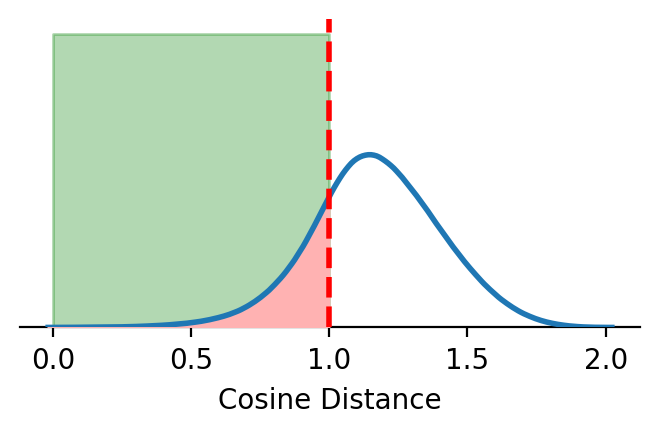

In [11]:
threshold = 1.0

x_data = D.to_numpy().ravel()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2

sns.kdeplot(
    x=x_data,
    lw=2,
    zorder=4,
)

plt.axvline(
    x=threshold, 
    color='red', 
    linestyle='dashed', 
    linewidth=2,
    zorder=5,
)

# Get the x and y values from the KDE plot
kde_line = plt.gca().lines[0]
x_data, y_data = kde_line.get_data()

# Find the index of the point closest to the threshold
idx = np.argmin(np.abs(x_data - threshold))

plt.fill_between(
    x_data[:idx+1], 
    y_data[:idx+1], 
    color='#FFB2B2', 
    # alpha=0.3,
    zorder=3,
)

plt.fill_between(
    [0, 1], 
    [3, 3], 
    color='green', 
    alpha=0.3,
    zorder=2,
)

plt.yticks([])
plt.ylabel("")
plt.xlabel("Cosine Distance")
sns.despine(left=True)

/tmp/ipykernel_3198828/2616912768.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC,distance
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,8.989130,4.937538,...,C1,False,True,True,True,False,True,False,C1,0.809674
GCACATATCTCTCGCA_iHSC,9145.0,iHSC,iHSC,nan,12891,11,Reprogrammed Cells,D12,8.815907,6.020735,...,C1,False,True,False,False,False,False,False,C1,0.438609
GCACATATCGTGTGAT_iHSC,4772.0,iHSC,iHSC,nan,12053,11,Reprogrammed Cells,D12,9.942209,6.505333,...,C1,False,False,False,False,False,True,False,C1,0.544245
GCACATATCCTTGACC_iHSC,15821.0,iHSC,iHSC,nan,13945,11,Reprogrammed Cells,D12,8.035115,5.347263,...,C1,False,True,True,False,True,False,False,C1,0.458700
GCACATAGTTTCAGAC_iHSC,3960.0,iHSC,iHSC,nan,11581,1,Reprogrammed Cells,D2,10.040021,4.140203,...,C1,False,False,False,False,False,False,False,C1,0.277059


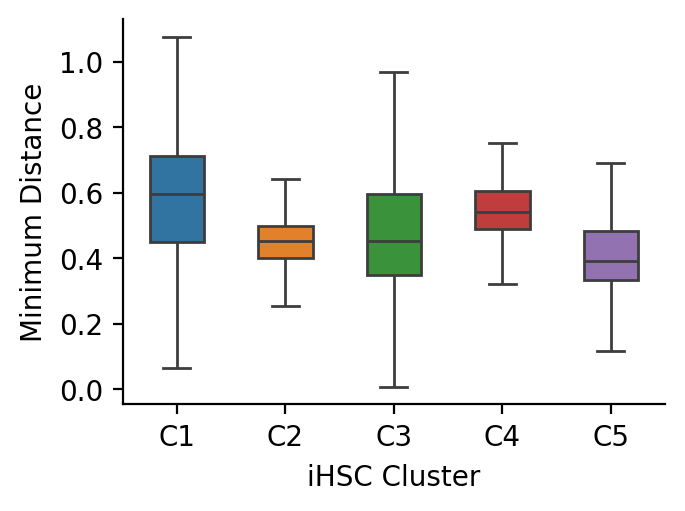

In [12]:
plot = ihsc.obs.copy()
plot['distance'] = D.min(axis=1)
plot = plot.sort_values(by='cluster_str_QC')

plot = plot[plot['cluster_str_QC'] != "C6"]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

sns.boxplot(
    data=plot,
    x='cluster_str_QC',
    y='distance',
    width=0.5,
    showfliers=False,
    palette='tab10',
)

sns.despine()

plt.ylabel('Minimum Distance')
plt.xlabel('iHSC Cluster')

plot.head()

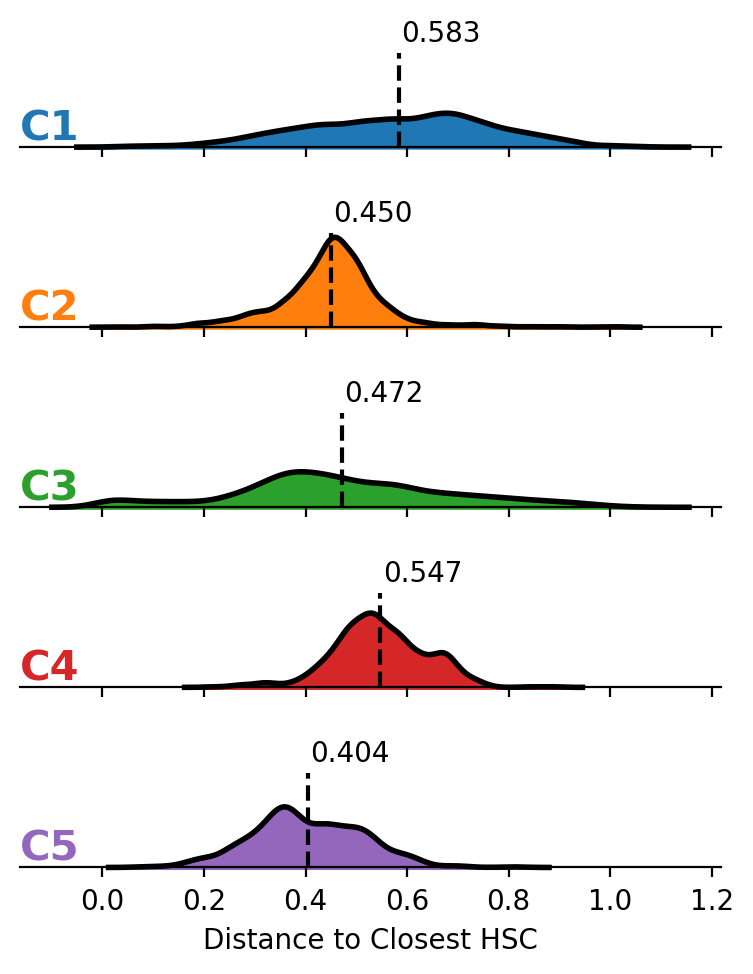

In [13]:
def create_facet_grid(df, x_col="x", group_col="g"):
    """
    Creates a faceted KDE plot for visualizing the distribution of a variable across groups.

    Args:
        df: The DataFrame containing the data.
        x_col: The name of the column containing the variable to plot.
        group_col: The name of the column containing the group labels.

    Returns:
        The FacetGrid object containing the plot.
    """
    g = sns.FacetGrid(
        df,
        row=group_col,
        hue=group_col,
        aspect=4.25,
        height=1,
        palette='tab10',
    )

    # Draw the densities
    g.map(
        sns.kdeplot, 
        x_col, 
        bw_adjust=0.75, 
        clip_on=False, 
        fill=True, 
        alpha=1, 
        linewidth=1.5,
    )
    
    g.map(
        sns.kdeplot, 
        x_col, 
        clip_on=False, 
        color="k", 
        lw=2, 
        bw_adjust=0.75,
    )
    
   # Calculate and add vertical lines for means
    def add_mean_line(x, **kwargs):
        ax = plt.gca()
        mean_value = df[df[group_col] == kwargs['label']][x_col].mean()
        ax.axvline(mean_value, color='k', linestyle='dashed', linewidth=1.5)
        
        
   # Calculate and add vertical lines for means
    def add_mean_annot(x,  **kwargs):
        ax = plt.gca()
        mean_value = df[df[group_col] == kwargs['label']][x_col].mean()
        ax.text(mean_value+0.005, 7, f"{mean_value:.3f}")

    g.map(add_mean_line, x_col)
    g.map(add_mean_annot, x_col)
    
    
    # Add labels
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            fontsize=15,
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, x_col)

    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel="Distance to Closest HSC")
    g.despine(left=True)

    return g


create_facet_grid(plot, x_col='distance', group_col='cluster_str_QC')

# Diagnositic

In [14]:
plot.columns

Index(['n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes',
       'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2',
       'cell_id', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC',
       'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC',
       'OG_cluster_QC', 'distance'],
      dtype='object')

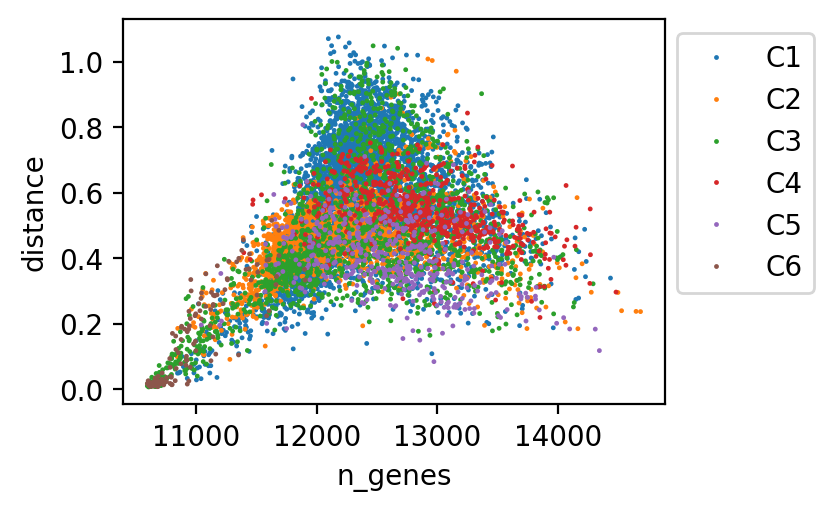

In [15]:
plot = ihsc.obs.copy()
plot['distance'] = D.min(axis=1)
plot = plot.sort_values(by='cluster_str_QC')

sns.scatterplot(
    data=plot,
    x='n_genes',
    y='distance',
    hue='cluster_str_QC',
    s=3,
    ec='none',
    palette='tab10',
)

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title='',
    bbox_to_anchor=(1.3, 1),
)

# renormalize

In [16]:
def drop_zero_sum_columns(df):
    """Drops columns from a DataFrame where the sum is zero.

    Args:
        df: The pandas DataFrame to process.

    Returns:
        The modified DataFrame with zero-sum columns removed.
    """

    # Calculate column sums
    column_sums = df.sum(axis=0)

    # Identify zero-sum columns (including all NaN)
    columns_to_drop = column_sums[(column_sums == 0) | (column_sums.isna())].index

    # Drop zero-sum columns
    df_updated = df.drop(columns_to_drop, axis=1)  

    return df_updated


def renormalize(adata):
    """Renormalizes an AnnData object by:

    1. Copying the existing 'X' matrix to a new layer called 'combat'.
    2. Replacing 'X' with the raw counts from 'raw_counts'.
    3. Filtering out genes expressed in only a single cell.
    4. Creating a new layer 'sqrt_norm' containing the square root of normalized counts.

    Args:
        adata: The AnnData object to renormalize.

    Returns:
        The renormalized AnnData object.
    """
    adata.layers['combat'] = adata.X.copy()
    adata.X = adata.layers['raw_counts'].copy()
    sc.pp.filter_genes(adata, min_cells=1) 
    adata.layers["sqrt_norm"] = np.sqrt(
        sc.pp.normalize_total(adata, inplace=False)["X"]
    )
    return adata
    
    
# renormalize    
hsc_renorm = renormalize(hsc)
ihsc_renorm = renormalize(ihsc)

# rejoin the normalized counts
hdf = an.concat(
    [hsc_renorm, ihsc_renorm],
    fill_value=0.0,
    join='inner', # switch to "outer" if we want genes not expressed in both datasets
)

sc.pp.filter_genes(hdf, min_cells=1) 

hdf

filtered out 3617 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
filtered out 4005 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 11817 × 12027
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC', 'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC', 'OG_cluster_QC'
    var: 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'log_norm', 'raw_counts', 'combat', 'sqrt_norm'

# distance over HSC genes

In [17]:
metric = 'cosine'
layer = 'sqrt_norm'

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2', 'APC', 'BMI1', 'FGD5',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]

ihsc = hdf[hdf.obs['cell_type'] == 'iHSC', :].copy()
hsc = hdf[hdf.obs['cell_type'] == 'HSC', :].copy()

X_ihsc = ihsc[:, gene_list].to_df(layer=layer)
X_hsc = hsc[:, gene_list].to_df(layer=layer)

print(f"{X_ihsc.shape=}")
print(f"{X_hsc.shape=}")

D = cdist(
    X_ihsc, 
    X_hsc, 
    metric=metric,
)

D = pd.DataFrame(
    D, 
    index=ihsc.obs_names,
    columns=hsc.obs_names,
)

print(f"{D.shape=}")
print(f"Min Distance {np.min(D):4f}")
print(f"Max Distance {np.max(D):4f}")
print(f"Mean Distance {np.mean(D):4f}")

D.head()

X_ihsc.shape=(8574, 25)
X_hsc.shape=(3243, 25)
D.shape=(8574, 3243)
Min Distance 0.078445
Max Distance 1.000000
Mean Distance 0.668579


,AAACAGCCAACCCTAA-3_young2_HSC,AAACAGCCATAGGCGA-3_young2_HSC,AAACATGCAGGCTGTT-3_young2_HSC,AAACCGCGTCCTTAGT-3_young2_HSC,AAACCGCGTCCTTTAA-3_young2_HSC,AAACCGGCAATAGCCC-3_young2_HSC,AAACCGGCAATGCCCG-3_young2_HSC,AAACCGGCAGCCTTGG-3_young2_HSC,AAACGCGCACCAACCG-2_young2_HSC,AAACGGATCCCTGACT-3_young2_HSC,...,TTTGTCCCAATAATCC-3_young2_HSC,TTTGTCCCACTTCATC-3_young2_HSC,TTTGTCCCAGTCTAGC-3_young2_HSC,TTTGTCCCATTGTCCT-3_young2_HSC,TTTGTCTAGCAAGGGT-2_young2_HSC,TTTGTGAAGCCTAATA-3_young2_HSC,TTTGTGGCACACCAAC-3_young2_HSC,TTTGTGGCATCTAGCA-2_young2_HSC,TTTGTGGCATTGGGAG-3_young2_HSC,TTTGTTGGTACGTTTC-3_young2_HSC
AAACCCAAGGTTACCT_iHSC,0.693085,0.694547,0.595730,0.643380,0.684530,0.560126,0.644922,0.568955,0.589339,0.563670,...,0.607487,0.738717,0.753115,0.714606,0.721103,0.624107,0.689792,0.617863,0.721458,0.620285
AAACCCAAGTTGAAGT_iHSC,0.460327,0.414502,0.433919,0.486620,0.495333,0.439074,0.446658,0.624500,0.538379,0.569060,...,0.589081,0.528930,0.549775,0.702204,0.432630,0.526918,0.600265,0.445031,0.593199,0.561869
AAACCCAAGTTGTCGT_iHSC,0.529178,0.702706,0.372904,0.701319,0.595366,0.644293,0.576222,0.496899,0.481843,0.494122,...,0.599867,0.559377,0.473397,0.544237,0.462477,0.527489,0.474277,0.531775,0.494111,0.550611
AAACCCACAGAAGCGT_iHSC,0.899496,0.795876,0.597678,0.678873,0.683772,0.724759,0.792610,0.910913,0.718552,0.884530,...,0.642305,0.738495,1.000000,0.731326,0.831768,0.876909,0.696289,0.789181,0.682678,0.759437
AAACCCACAGGAGGTT_iHSC,0.497585,0.459145,0.571721,0.419324,0.574246,0.580369,0.582753,0.800861,0.565876,0.586104,...,0.592697,0.550359,0.845747,0.656047,0.639273,0.419330,0.660961,0.482654,0.671019,0.652771


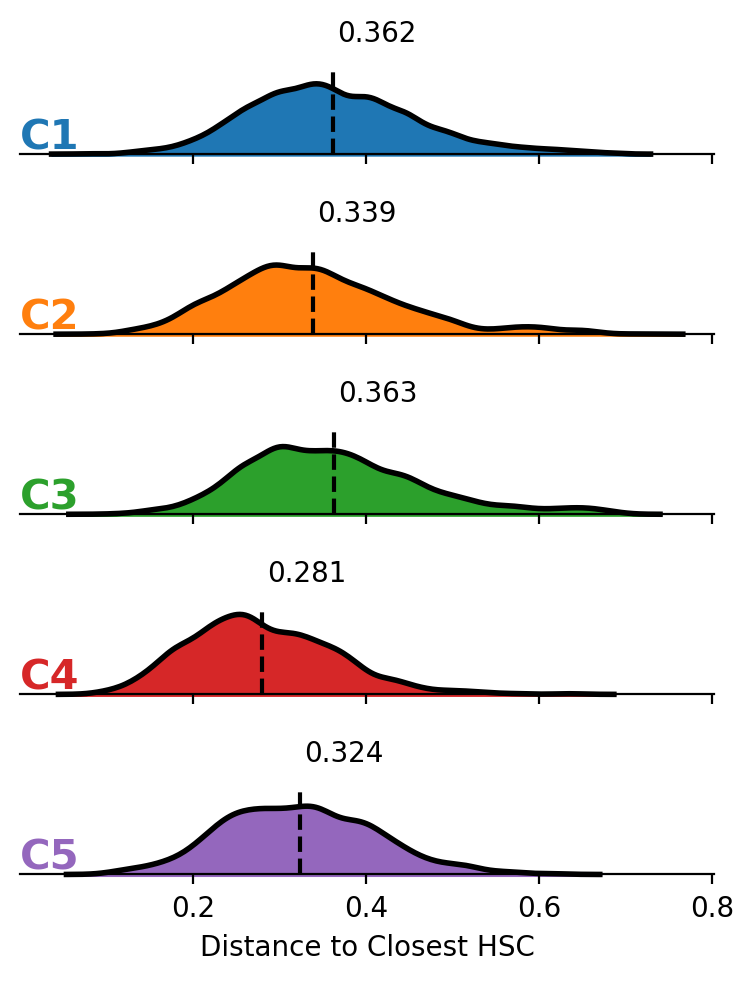

In [18]:
plot = ihsc.obs.copy()
plot['distance'] = D.min(axis=1)
plot = plot.sort_values(by='cluster_str_QC')

plot = plot[plot['cluster_str_QC'] != "C6"]

create_facet_grid(plot, x_col='distance', group_col='cluster_str_QC')

# Single-cell Plots

In [19]:
def analyze_hdf_distances(hdf, D, threshold=1.0, layer='sqrt_norm', 
                          thresh_type='less', sample_size=50):
    """Analyzes distances within an hdf object and returns a dataframe.

    Args:
        hdf: The hdf object to analyze.
        D: The distance matrix.
        threshold: The threshold for considering distances as "close".
        thresh_type: either 'leq' or 'geq' for the different thresholding logic
        layer: The layer to extract from the hdf object.
        sample_size: The number of samples to take from each group.

    Returns:
        A dataframe containing the sampled data.
    """

    distances = D.mean(axis=1)
    distances = distances[distances.index.isin(hdf.obs_names)]

    if thresh_type == 'leq':
        idx = distances[distances <= threshold].index
    else:
        idx = distances[distances >= threshold].index
        
    n = idx.shape[0]
    print(f"{threshold=} {n=}")

    df = pd.concat([
        hdf[idx, :].to_df(layer=layer).sample(sample_size),
        hdf[hdf.obs['cell_type'] == 'HSC', :].to_df(layer=layer).sample(sample_size),
    ], ignore_index=False,)

    print(f"{df.shape=}")

    return df

THRESHOLD = 0.5
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
    thresh_type='leq', # get closest cells
)

df.head()

threshold=0.5 n=532
df.shape=(100, 12027)


gene_name,A1BG,A2M,A2ML1,A3GALT2,AAAS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM7,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
TTCCTTCAGATGCGAC_iHSC,0.0,0.0,0.814598,0.814598,0.0,0.0,0.814598,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
CCATCACGTAAGTAGT_iHSC,0.0,0.0,1.375302,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
GCTTCACCACGACAAG_iHSC,0.0,0.0,1.214193,0.858564,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
CCACGAGCAAACACGG_iHSC,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.821365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
ATGTCTTTCACCTTAT_iHSC,0.0,0.0,0.000000,0.000000,0.0,0.0,1.148054,0.0,0.0,1.148054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.811797,0.0,0.0


threshold=0.5 n=532
df.shape=(100, 12027)


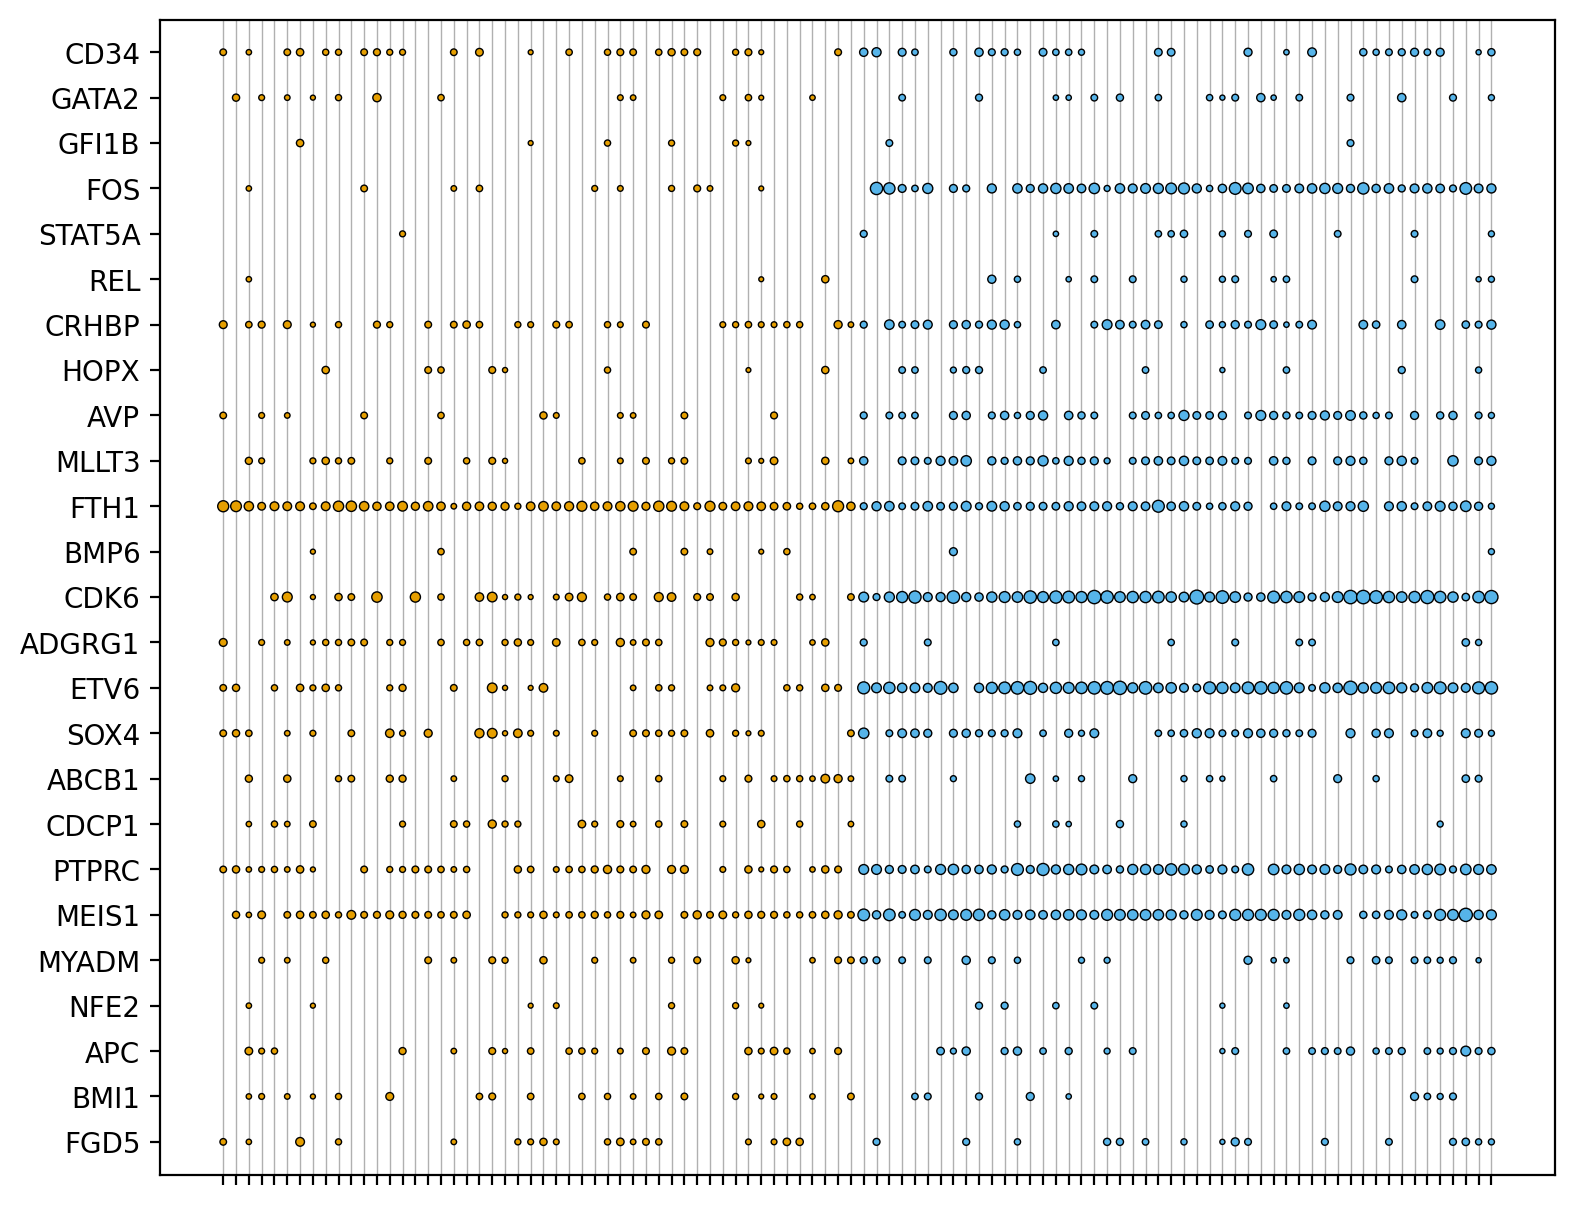

In [20]:
# gene_list = pdf.uns['go_annotations']['gene_name'].to_list()

THRESHOLD = 0.5
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
     thresh_type='leq', # get closest cells
)

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2', 'APC', 'BMI1', 'FGD5',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]
gene_list = [x for x in gene_list if x in df.columns]

plot = df[gene_list].reset_index(names='cell_id')
plot = pd.melt(plot, id_vars='cell_id')

plot['dataset'] = plot['cell_id'].apply(lambda x: x.split("_")[-1])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, (len(gene_list) * 0.3)

sns.scatterplot(
    data=plot,
    x='cell_id',
    y='gene_name',
    size='value',
    marker=".",
    hue='dataset',
    lw=0.5,
    ec='k',
    sizes=(0.0, 100),
    palette=["#E69F00", "#56B4E9"],
    zorder=5,
    legend=False,
)

plt.grid(axis='x', lw=0.5, zorder=0) 
# plt.xticks([])

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', labelsize=1, labelcolor='w')
plt.margins(y=0.03,)

plt.show()

# Furthest cells

threshold=0.8 n=986
df.shape=(100, 12027)


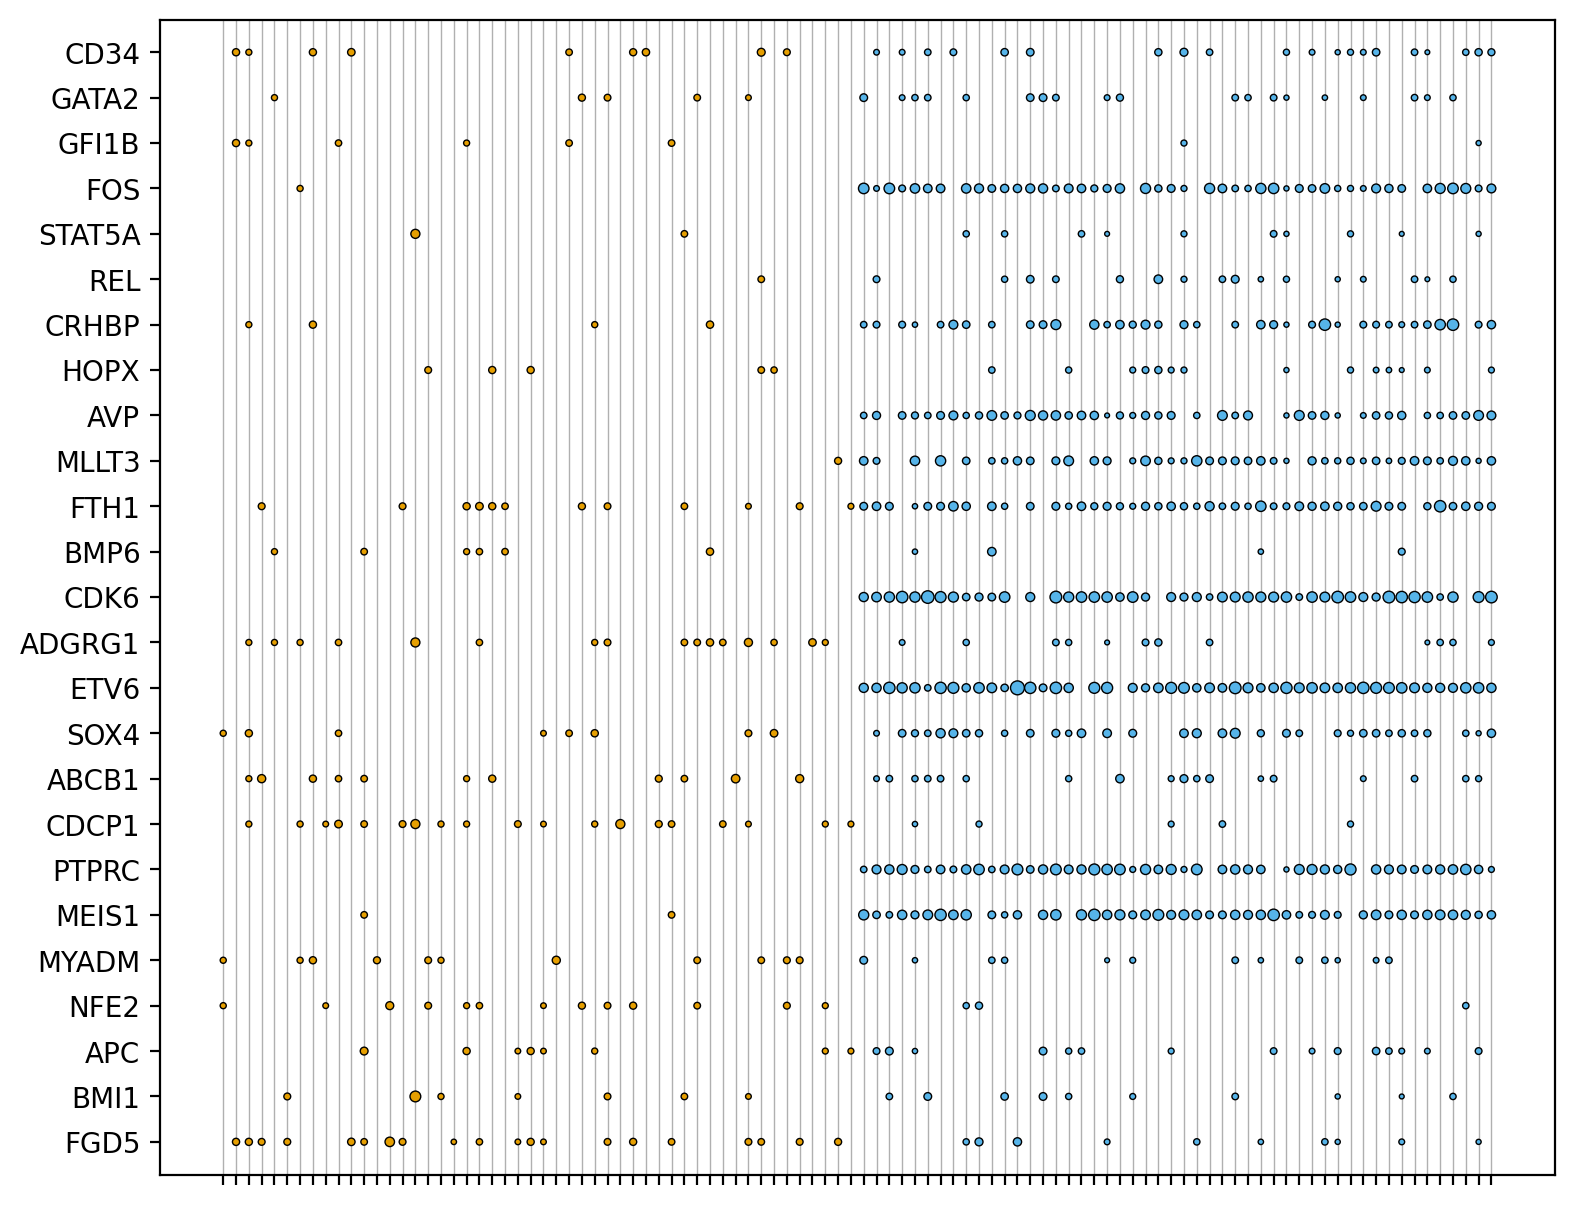

In [21]:
# gene_list = pdf.uns['go_annotations']['gene_name'].to_list()

THRESHOLD = 0.8
df = analyze_hdf_distances(
    hdf, D, 
    threshold=THRESHOLD,
     thresh_type='geq', # get closest cells
)

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2', 'APC', 'BMI1', 'FGD5',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]
gene_list = [x for x in gene_list if x in df.columns]

plot = df[gene_list].reset_index(names='cell_id')
plot = pd.melt(plot, id_vars='cell_id')

plot['dataset'] = plot['cell_id'].apply(lambda x: x.split("_")[-1])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, (len(gene_list) * 0.3)

sns.scatterplot(
    data=plot,
    x='cell_id',
    y='gene_name',
    size='value',
    marker=".",
    hue='dataset',
    lw=0.5,
    ec='k',
    sizes=(0.0, 100),
    palette=["#E69F00", "#56B4E9"],
    zorder=5,
    legend=False,
)

plt.grid(axis='x', lw=0.5, zorder=0) 
# plt.xticks([])

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', labelsize=1, labelcolor='w')
plt.margins(y=0.03,)

plt.show()

# Comp w/ negative controls

In [22]:
threshold = 0.25

hdf.obs['dist_cat'] = 'HSC'

min_dist = D.min(axis=1).reset_index()
min_dist.columns = ['cell_id', 'min_dist']
min_dist['dist_cat'] = min_dist['min_dist'] < threshold

# map iHSC distance into hdf
hdf.obs['dist_cat'] = np.where(hdf.obs.index.isin(min_dist[min_dist['dist_cat']]['cell_id'].values), 'Close', hdf.obs['dist_cat'])
hdf.obs['dist_cat'] = np.where(hdf.obs.index.isin(min_dist[~min_dist['dist_cat']]['cell_id'].values), 'Far', hdf.obs['dist_cat'])

hdf.obs['dist_cat'].value_counts()

dist_cat
Far      7335
HSC      3243
Close    1239
Name: count, dtype: int64

# DEG by distance 

In [23]:
tmp = hdf[hdf.obs['cell_type'] == 'iHSC', :].copy()

sc.tl.rank_genes_groups(
    tmp, 
    groupby="dist_cat",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    layer='sqrt_norm',
    key_added='hsc_deg',
)

deg = sc.get.rank_genes_groups_df(
    tmp, 
    group=None,
    key='hsc_deg',
)

deg.head()

ranking genes


... storing 'cluster_str_QC' as categorical
... storing 'OG_cluster_QC' as categorical
... storing 'dist_cat' as categorical


    consider 'dist_cat' groups:
    with sizes: [1239 7335]
    finished: added to `.uns['hsc_deg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,Close,MEIS1,21.984291,1.356972,4.071046e-107,4.896246e-103,0.761098,0.376005
1,Close,PTPRC,20.705925,1.753042,3.062969e-95,1.841917e-91,0.577078,0.209816
2,Close,FTH1,15.441742,0.713696,8.575319e-54,3.437845e-50,0.959645,0.780913
3,Close,ETV6,15.120403,2.123240,1.188124e-51,3.572392e-48,0.364003,0.094751
4,Close,EPN1,12.902190,0.662237,4.374848e-38,1.052326e-34,0.884584,0.785003


In [24]:
sig = deg.copy()

pvals_adj = 0.05
logfoldchanges = 0.5

sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]

sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
sig

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
5,Close,CDK6,12.741040,2.554230,3.497011e-37,7.009759e-34,0.287328,0.065849
142,Close,RBIS,6.865798,2.172710,6.612030e-12,5.097621e-10,0.160613,0.039536
513,Close,GPR142,4.706367,2.146686,2.521707e-06,5.444986e-05,0.108959,0.025631
140,Close,MAPKAPK2,6.900110,2.142610,5.196244e-12,4.058132e-10,0.163842,0.041990
3,Close,ETV6,15.120403,2.123240,1.188124e-51,3.572392e-48,0.364003,0.094751
...,...,...,...,...,...,...,...,...
12033,Far,TOMM70,7.952736,0.658918,1.824360e-15,2.581362e-13,0.873892,0.871671
12055,Far,MINDY1,5.302224,0.601018,1.144006e-07,3.630333e-06,0.998364,1.000000
12041,Far,ZSWIM6,6.707044,0.575986,1.986068e-11,1.438942e-09,0.885481,0.886199
12093,Far,ZNF416,3.261217,0.554810,1.109350e-03,9.246121e-03,0.927335,0.939467


# plot em

Close
  dist_cat gene_name     value
0      Far      CDK6  0.000000
1    Close      CDK6  0.000000
2    Close      CDK6  1.723362
3      Far      CDK6  0.000000
4      Far      CDK6  0.000000


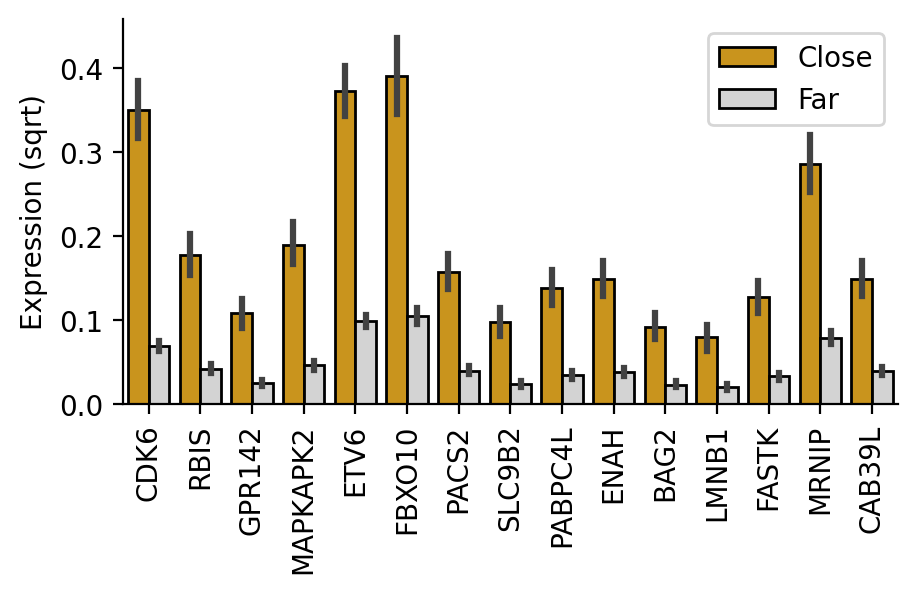

Far
  dist_cat gene_name     value
0      Far      KLF2  6.568196
1    Close      KLF2  5.829045
2    Close      KLF2  4.221358
3      Far      KLF2  4.533111
4      Far      KLF2  9.488404


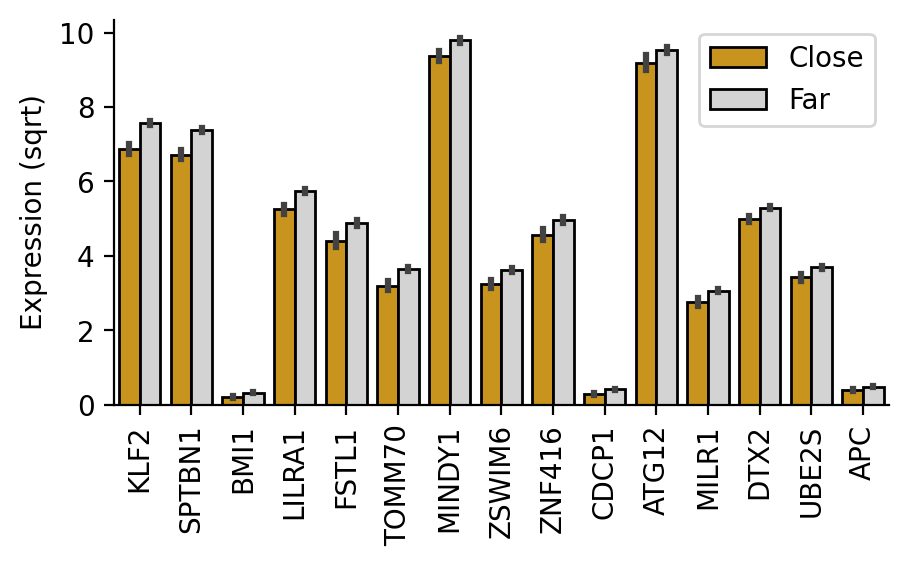

In [25]:
sig = deg.copy()

n_genes = 15
pvals_adj = 0.05
logfoldchanges = 0.25

sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] >= logfoldchanges]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5

for group_name, group in sig.groupby('group'):
    
    print(group_name)
    
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    plot = tmp[:, group['names'].head(n_genes).values].to_df(layer='sqrt_norm')
    plot['dist_cat'] = tmp.obs['dist_cat']
    plot = pd.melt(plot, id_vars='dist_cat',)
    print(plot.head())

    plt.rcParams['figure.facecolor'] = 'none'

    sns.barplot(
        data=plot, 
        x='gene_name',
        y='value',
        hue='dist_cat',
        palette=["#E69F00", 'lightgrey', "#56B4E9"],
        ec='k',
    )
    
    plt.ylabel("Expression (sqrt)")
    plt.xlabel("")

    plt.gca().tick_params(axis='x', rotation=90)

    sns.move_legend(
        plt.gca(),
        loc='best',
        title=""
    )
    sns.despine()
    plt.show()
    
    # break


Tue Aug 13 14:40:36 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


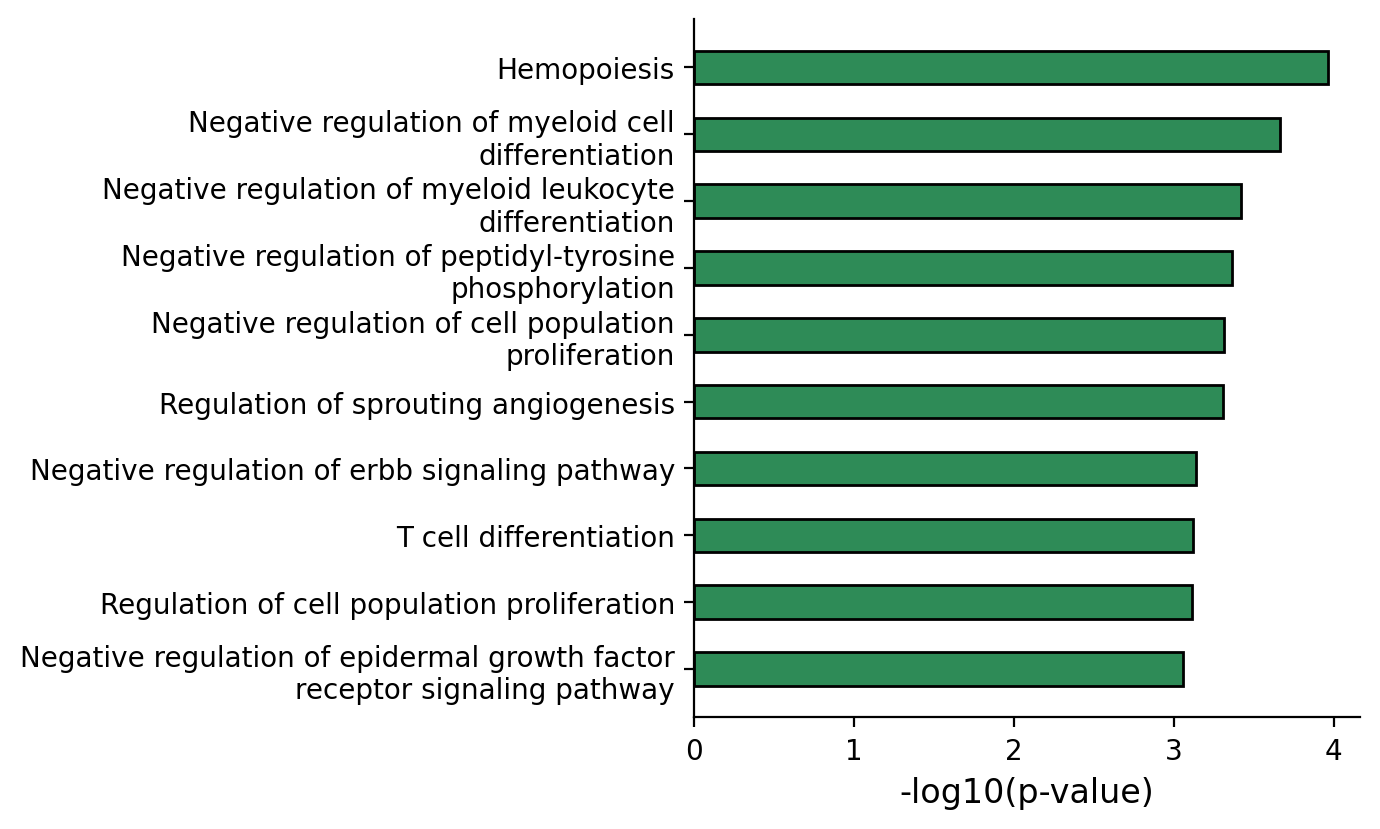

In [26]:
def plot_pathway_enrichment(df):
    """
    Plots pathway enrichment results from a DataFrame.

    Args:
        df: DataFrame containing 'path_name' and 'p_val' columns.
    """
    
    # Sort and calculate -log10(p_val)
    df_sorted = df.sort_values('p_val')
    df_sorted['neg_log10_pval'] = -np.log10(df_sorted['p_val'])
    df_sorted['pname'] = df_sorted['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    
    wrapped_labels = [fill(label, 50) for label in df_sorted['pname']]

    # Create the plot
    plt.barh(
        wrapped_labels, 
        df_sorted['neg_log10_pval'], 
        color='seagreen',
        height=0.5,
        ec='k',
    )

    # Set labels and title
    plt.xlabel('-log10(p-value)', fontsize=12)

    # Invert y-axis and set x-axis ticks/limits
    plt.gca().invert_yaxis() 
    sns.despine()

    # Show the plot
    plt.tight_layout()

database = 'ontology'
n_genes = 20
n_pathways = 10
group = 'Close'

gsea = gget.enrichr(sig[sig['group'] == group]['names'].head(n_genes).to_list(), database)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4.25
plot_pathway_enrichment(gsea.head(n_pathways))

In [27]:
gsea.head(10)

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,hemopoiesis (GO:0030097),0.000108,38.569489,352.213461,"[MEIS1, PTPRC, ETV6]",0.023634,GO_Biological_Process_2021
1,2,negative regulation of myeloid cell differenti...,0.000217,110.888889,935.499801,"[MEIS1, CDK6]",0.023634,GO_Biological_Process_2021
2,3,negative regulation of myeloid leukocyte diffe...,0.000380,82.111111,646.758780,"[CDK6, PTPN2]",0.023634,GO_Biological_Process_2021
3,4,negative regulation of peptidyl-tyrosine phosp...,0.000434,76.440613,591.814177,"[PTPRC, PTPN2]",0.023634,GO_Biological_Process_2021
4,5,negative regulation of cell population prolife...,0.000483,13.070000,99.782612,"[CDK6, FTH1, ADAMTS8, PTPN2]",0.023634,GO_Biological_Process_2021
5,6,regulation of sprouting angiogenesis (GO:1903670),0.000492,71.501792,544.577856,"[GLUL, EPN1]",0.023634,GO_Biological_Process_2021
6,7,negative regulation of ERBB signaling pathway ...,0.000724,58.309942,421.597121,"[PTPN2, EPN1]",0.024682,GO_Biological_Process_2021
7,8,T cell differentiation (GO:0030217),0.000761,56.811966,407.959182,"[PTPRC, PTPN2]",0.024682,GO_Biological_Process_2021
8,9,regulation of cell population proliferation (G...,0.000771,8.441370,60.502667,"[MEIS1, CDK6, FTH1, ADAMTS8, PTPN2]",0.024682,GO_Biological_Process_2021
9,10,negative regulation of epidermal growth factor...,0.000876,52.746032,371.317612,"[PTPN2, EPN1]",0.025073,GO_Biological_Process_2021


In [37]:
database = 'PanglaoDB_Augmented_2021'
n_genes = 50
n_pathways = 10
group = 'Close'

gsea = gget.enrichr(sig[sig['group'] == group]['names'].head(n_genes).to_list(), database)

gsea.head(10)

Tue Aug 13 14:56:41 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Hematopoietic Stem Cells,0.001015,9.883058,68.122012,"[MEIS1, TYROBP, PTPRC, MPL]",0.049773,PanglaoDB_Augmented_2021
1,2,Dendritic Cells,0.001531,8.809365,57.098081,"[TYROBP, PTPRC, ARG1, ETV6]",0.049773,PanglaoDB_Augmented_2021
2,3,Nuocytes,0.002629,11.837145,70.325270,"[PTPRC, ARG1, RORA]",0.056966,PanglaoDB_Augmented_2021
3,4,Gamma (PP) Cells,0.004030,10.123404,55.820282,"[MEIS1, PXK, PCDHB4]",0.062055,PanglaoDB_Augmented_2021
4,5,Tuft Cells,0.004773,9.510638,50.831298,"[TYROBP, PTPRC, GNAT3]",0.062055,PanglaoDB_Augmented_2021
5,6,Plasmacytoid Dendritic Cells,0.006263,8.598784,43.622221,"[TYROBP, PTPRC, ETV6]",0.067851,PanglaoDB_Augmented_2021
6,7,Hepatocytes,0.017822,5.777474,23.267896,"[ARG1, GLUL, ADH6]",0.165486,PanglaoDB_Augmented_2021
7,8,Osteoclast Precursor Cells,0.029403,7.875000,27.772490,"[TYROBP, PTPRC]",0.188874,PanglaoDB_Augmented_2021
8,9,Myeloid-derived Suppressor Cells,0.031976,7.515152,25.872917,"[TYROBP, PTPRC]",0.188874,PanglaoDB_Augmented_2021
9,10,Satellite Glial Cells,0.033030,7.380208,25.169118,"[KCND3, GLUL]",0.188874,PanglaoDB_Augmented_2021


Tue Aug 13 14:40:37 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


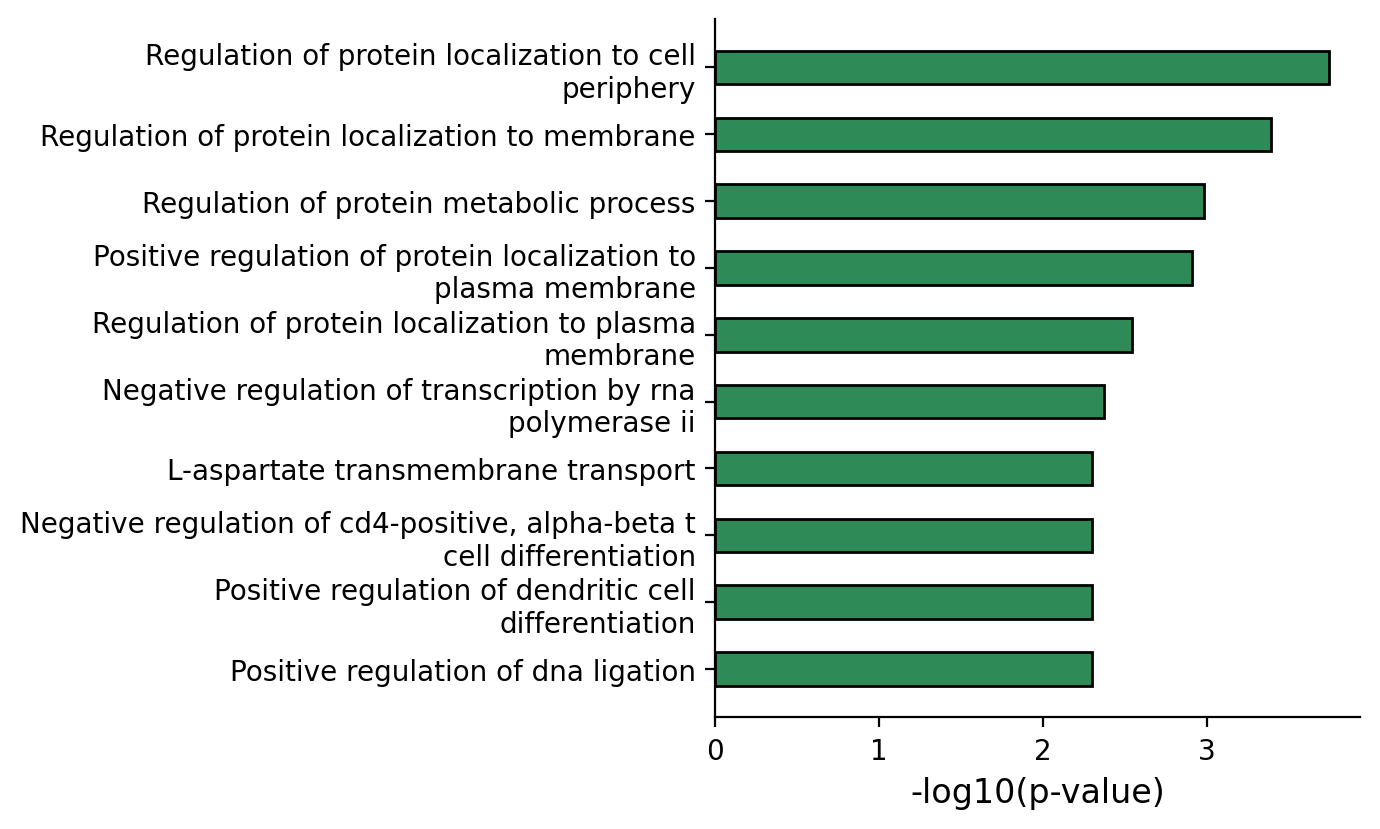

In [28]:
database = 'ontology'
n_genes = 20
n_pathways = 10
group = 'Far'

gsea = gget.enrichr(sig[sig['group'] == group]['names'].head(n_genes).to_list(), database)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4.25
plot_pathway_enrichment(gsea.head(n_pathways))

In [29]:
gsea.head(10)

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,regulation of protein localization to cell per...,0.000179,123.222222,1063.477584,"[ZDHHC2, SPTBN1]",0.054640,GO_Biological_Process_2021
1,2,regulation of protein localization to membrane...,0.000406,79.174603,618.213948,"[ZDHHC2, SPTBN1]",0.062175,GO_Biological_Process_2021
2,3,regulation of protein metabolic process (GO:00...,0.001042,48.149758,330.604092,"[ZDHHC2, KLF2]",0.068296,GO_Biological_Process_2021
3,4,positive regulation of protein localization to...,0.001223,44.288889,297.038399,"[ZDHHC2, SPTBN1]",0.068296,GO_Biological_Process_2021
4,5,regulation of protein localization to plasma m...,0.002865,28.350427,165.997247,"[ZDHHC2, SPTBN1]",0.068296,GO_Biological_Process_2021
5,6,negative regulation of transcription by RNA po...,0.004244,7.095588,38.758607,"[HMGB1, BMI1, DUSP26, KLF2]",0.068296,GO_Biological_Process_2021
6,7,L-aspartate transmembrane transport (GO:0070778),0.004990,262.842105,1393.123889,[SLC1A2],0.068296,GO_Biological_Process_2021
7,8,"negative regulation of CD4-positive, alpha-bet...",0.004990,262.842105,1393.123889,[HMGB1],0.068296,GO_Biological_Process_2021
8,9,positive regulation of dendritic cell differen...,0.004990,262.842105,1393.123889,[HMGB1],0.068296,GO_Biological_Process_2021
9,10,positive regulation of DNA ligation (GO:0051106),0.004990,262.842105,1393.123889,[HMGB1],0.068296,GO_Biological_Process_2021
